In [1]:
"""Extract ROIs from data and save them in separate images."""

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

from __future__ import division
import os
import os.path as P
import cv2
import copy
import math
import numpy as np

SCREEN_WIDTH = 1920
SCREEN_HEIGHT = 1080

MIN_HEIGHT = 32
MIN_ASPECT_RATIO = 0.6
MAX_ASPECT_RATIO = 6
TOL = 4



In [2]:
###unrotate###

def white_paper_mask(im, debug=False):
    """Locate white regions of the original image."""
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
    _, s, v = cv2.split(hsv)
    _, s = cv2.threshold(s, 64, 255, cv2.THRESH_BINARY_INV)
    _, v = cv2.threshold(v, 96, 255, cv2.THRESH_BINARY)
    mask = cv2.bitwise_and(s, v)
    return mask

def unrotate(original, debug=False):
    mask = white_paper_mask(original, debug)
    #
    # scale down so that we can use consistent number of iterations for morphological ops
    #
    scale = 512/original.shape[1]
    thresh = cv2.resize(mask, (0,0), fx=scale, fy=scale)
    scaled = cv2.resize(original, (0,0), fx=scale, fy=scale)

    num_iter = 1
    closed = cv2.dilate(cv2.erode(thresh, None, iterations=num_iter), None, iterations=num_iter)
    if debug:
        plt.imshow(closed)
        plt.show()

    _, contours, _= cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if debug:
        cv2.drawContours(scaled, contours, -1, (255, 0, 0))
        plt.imshow(scaled)
        plt.show()

    #
    # Pick the quad with the largest area
    #
    quads = []
    for contour in contours:
        #
        # TODO: check if the contour is rectangular enough
        #
        area = cv2.contourArea(contour)

        #
        # TODO: How to decide this threshold?
        # TODO: order the vertices in the decided polygon in some predictable way
        #
        poly = cv2.approxPolyDP(contour, 50, True)
        if len(poly) == 4:
            quads.append((area, poly))
       
    assert quads

    #
    # Pick the largest quad, by area
    #
    quad = sorted(quads, reverse=True)[0][1]
    a_x = quad[0][0][0]
    a_y = quad[0][0][1]
    b_x = quad[1][0][0]
    b_y = quad[1][0][1]
    d_x = quad[2][0][0]
    d_y = quad[2][0][1]
    e_x = quad[3][0][0]
    e_y = quad[3][0][1]
    width = math.sqrt((a_x-b_x)**2 + (a_y-b_y)**2)
    height = math.sqrt((b_x-d_x)**2 + (b_y-d_y)**2)

    if debug:
        cv2.circle(scaled, (int(a_x), int(a_y)), 5, (255, 0, 0), -1)   # blue
        cv2.putText(scaled, "A", (int(a_x), int(a_y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0))
        cv2.circle(scaled, (int(b_x), int(b_y)), 5, (0, 255, 0), -1)   # green
        cv2.putText(scaled, "B", (int(b_x), int(b_y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0))
        cv2.circle(scaled, (int(d_x), int(d_y)), 5, (0, 0, 255), -1)   # red
        cv2.putText(scaled, "D", (int(d_x), int(d_y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255))
        cv2.circle(scaled, (int(e_x), int(e_y)), 5, (255, 255, 0), -1) # cyan
        cv2.putText(scaled, "E", (int(e_x), int(e_y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0))
        plt.imshow(scaled)
        plt.show()
    #
    # Scale up to the original image and calculate a perspective transform
    #
    A_x, A_y, B_x, B_y, D_x, D_y, E_x, E_y = map(lambda x: x/scale, [a_x, a_y, b_x, b_y, d_x, d_y, e_x, e_y])
    Width, Height = width/scale, height/scale

    src = np.array([(A_x, A_y), (B_x, B_y), (D_x, D_y), (E_x, E_y)], dtype="float32")
    dst = np.array([(Width, 0), (0, 0), (0, Height), (Width, Height)], dtype="float32")

    perspective = cv2.getPerspectiveTransform(src, dst)

    warped = cv2.warpPerspective(original, perspective, (0, 0))
    warped = warped[:Height, :Width]
    if width > height:
        warped = cv2.flip(cv2.transpose(warped), 1)

    return warped



In [3]:
###binarize###

def binarize(im, debug=False):
    ycrcb = cv2.cvtColor(im, cv2.COLOR_BGR2YCR_CB)
    y, cr, cb = cv2.split(ycrcb)
    #
    # TODO: how to reliably determine these parameters?
    #
    bsize = 9
    C = 8
    thresh = cv2.adaptiveThreshold(y, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, bsize, C)
    #thresh = cv2.adaptiveThreshold(y, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, bsize, C)
    return thresh





In [23]:
###cc###

def is_good_roi(roi):
    """Checks the aspect ratio and minimum size of the ROI.
    Returns True if it's OK."""
    x,y,width,height = roi
    return height >= MIN_HEIGHT and MIN_ASPECT_RATIO <= height/width <= MAX_ASPECT_RATIO

def is_overlap(r1, r2):
    """Returns True if the two ROIs overlap."""
    #
    # r1 is always on the left
    #
    if r2[0] < r1[0]:
        r1, r2 = r2, r1
    x1, y1, w1, h1 = r1
    x2, y2, w2, h2 = r2

    if not x1 <= x2 <= x1+w1:
        return False

    return (y1 <= y2 <= y1+h1) or (y2 <= y1 <= y2+h2)

def merge(r1, r2):
    """Merge two ROIs, assuming they overlap."""
    x1, y1, w1, h1 = r1
    x2, y2, w2, h2 = r2

    xx1 = min(x1, x2)
    yy1 = min(y1, y2)
    xx2 = max(x1+w1, x2+w2)
    yy2 = max(y1+h1, y2+h2)

    ww = xx2 - xx1
    hh = yy2 - yy1
    return (xx1, yy1, ww, hh)

def merge_overlaps(rois):
    """Perform a single iteration of overlapping ROIs.
    Returns the number of overlaps merged."""
    merged = []
    #used = [False]*len(rois)
    used = [False]*len(list(rois))    
    for i,r1 in enumerate(rois):
        if used[i]:
            continue
        for j,r2 in enumerate(rois):
            if j <= i or used[j]:
                continue
            if is_overlap(r1, r2):
                merged.append(merge(r1, r2))
                used[i] = used[j] = True
    #num_merged = len(merged)
    num_merged = len(list(merged))
    for i,r in enumerate(rois):
        if used[i]:
            continue
        merged.append(r)

    return merged, num_merged

def roi_compare(roi1, roi2):
    x1, y1, _, _ = roi1
    x2, y2, _, _ = roi2
    x1 //= 8
    x2 //= 8
    y1 //= 8
    y2 //= 8
    if y1 < y2:
        return -1
    elif y1 > y2:
        return 1

    if x1 < x2:
        return -1
    elif x1 > x2:
        return 1

    return 0



    

def get_rois(binarized, numiter=1):
    #
    # findContours uses the input image as scratch space
    #
    tmp = copy.deepcopy(binarized)
    #
    # Open the image to get rid of "holes" in the border
    #
    tmp = cv2.erode(cv2.dilate(tmp, None, iterations=numiter), None, iterations=numiter)
    #contours, _= cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    _, contours, _ = cv2.findContours(tmp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rois = map(lambda x: cv2.boundingRect(x), contours)
    print("printing rois")
    print(rois)
    #cnt = 0
    #while True:
    #    print (cnt)
    #    cnt = cnt + 1
    #    rois, num_merged = merge_overlaps(rois)
    #    if num_merged == 0:
    #        break
    #roisf = filter(is_good_roi, rois)
    #rois = list(roisf)
    #rois = list(rois)
    #rois.sort(key=roi_compare)  
    return rois
    #rois.sort(cmp=roi_compare)  
    #return sorted (rois,cmp=roi_compare)  


In [108]:
###collect_data###
def find_text_rep (x,y,w,h,rois):
    pass

def find_center (im):
    print("image shape")
    print(im.shape)
    w = im.shape[0]/2 
    h = im.shape[1]/2
    return (int(h),int(w))

def find_search_region(cx,cy,imx,imy):
    pass


def imshow_large(im):
    """Show an image such that it fits on the entire screen."""
    if im.shape[0] < SCREEN_HEIGHT and im.shape[1] < SCREEN_WIDTH:
        #cv2.imshow(window_name, im)
        plt.imshow(im)
        plt.show()
        return 

    if im.shape[0] > im.shape[1]:
        scale = SCREEN_HEIGHT/im.shape[0]
    else:
        scale = SCREEN_WIDTH/im.shape[1]

    scaled = cv2.resize(im, (0,0), fx=scale, fy=scale) 
    #cv2.imshow(window_name, scaled)
    plt.imshow(scaled)
    plt.show()
    return

def main():
    
    #im = cv2.imread('document-scanner/images/receipt.jpg')
    #im = cv2.imread('document-scanner/images/dm.jpg')
    #im = cv2.imread('document-scanner/images/braums-4.jpg')
    im = cv2.imread('document-scanner/images/hd1.jpg')
    im = cv2.GaussianBlur(im, (3,3), 0)
    print("showing original")
    imshow_large(im)
    
    print("showing unrotated")
    unrotated = unrotate(im)    
    imshow_large(unrotated)        
    #unrotated = cv2.flip(cv2.flip(unrotated, 0), 1)
    print("showing rotated")
    imshow_large(unrotated)

    print("showing binarized")
    binarized = binarize(unrotated)
    imshow_large(binarized)

    scale = SCREEN_HEIGHT/unrotated.shape[0]
    colorbin = copy.deepcopy(unrotated)
    colorbin = cv2.resize(colorbin, (0,0), fx=scale, fy=scale) 
     
        
    ###
    #my code goes here
    myimg = colorbin
    print("finding center")    
    cx,cy = find_center(myimg)
    print(find_center(myimg))   
    print("printint center")
    cv2.rectangle(myimg, (cx,cy), (cx+15, cy+15), (0,0,50,0), 4)
    imshow_large(myimg)
    imgboxed = Image.fromarray(myimg)
    #imgboxed.save("document-scanner/images/out/hd1-myimg.png")
    ###
        
    rois = get_rois(binarized)
    print ("rois length")
    #print (len(list(rois)))
    pos = 0
    
    print("BEFORE loop")
    for (x,y,width,height) in rois:
        #print("in loop")
        #print (pos,x,y,width,height)
        if pos >= 100 and pos <= 110:
            print (pos,x,y,width,height)
            x = int(x*scale)
            y = int(y*scale)
            width = int(width*scale)
            height = int(height*scale)
            cv2.rectangle(colorbin, (x,y), (x+width, y+height), (255,0,0,0), 1)
        pos = pos + 1
        
        
    print("showing colorbin")        
    plt.imshow(colorbin)
    plt.show()
    imgboxed = Image.fromarray(colorbin)
    imgboxed.save("document-scanner/images/out/hd1-rois.png")

    
    print("before deep copy loop")
    
    print (rois)
    
    for (x,y,width,height) in rois:
        print("in deep copy loop")
        
        colorbin2 = copy.deepcopy(colorbin)
        x_ = int(x*scale)
        y_ = int(y*scale)
        width_ = int(width*scale)
        height_ = int(height*scale)
        cv2.rectangle(colorbin2, (x_,y_), (x_+width_, y_+height_), (0,0,255,0), 1)

        sub = unrotated[y:y+height, x:x+width]
        supers = cv2.resize(sub, (192, 192), interpolation=cv2.INTER_NN)

        plt.imshow(colorbin2)
        plt.show()

        img = Image.fromarray(colorbin2)
        img.save("document-scanner/images/out/hd.png")


showing original


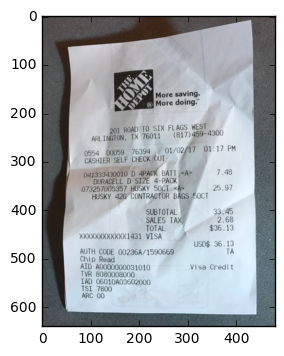

showing unrotated


/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:92: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


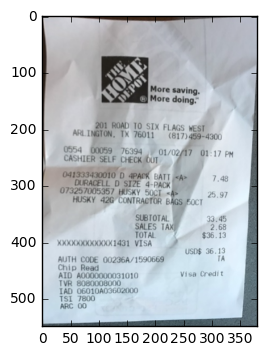

showing rotated


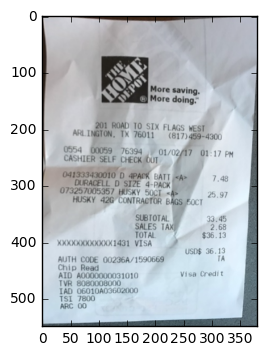

showing binarized


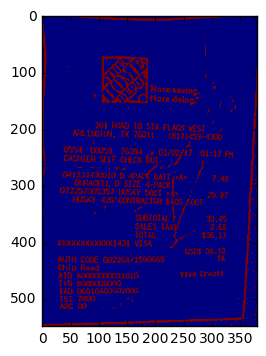

finding center
image shape
(1080, 748, 3)
image shape
(1080, 748, 3)
(374, 540)
printint center


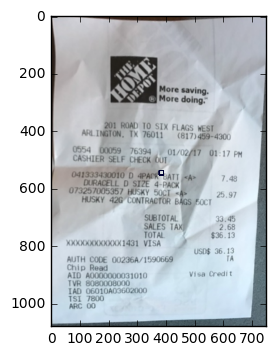

printing rois
rois length
BEFORE loop
100 306 377 2 3
101 373 374 1 2
102 278 374 2 3
103 284 371 1 2
104 296 369 8 11
105 290 369 1 1
106 310 368 14 12
107 210 368 5 12
108 164 367 38 13
109 306 363 3 3
110 370 361 2 1
showing colorbin


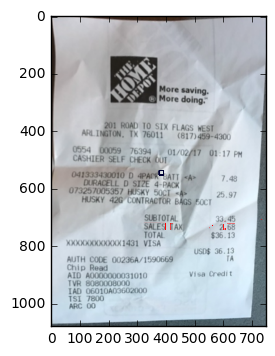

before deep copy loop


In [109]:


main()